In [1]:
import pandas as pd 
import numpy as np 
import os 
from glob import glob

from PIL import Image 

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from tqdm import tqdm 

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

d:\thiago\phd\gradvec\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('HAM10000_metadata')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [3]:
df['cell_type'] = df['dx'].map(lesion_type_dict.get)

In [4]:
df['image_id'] += '.jpg'

#### Let us select Dermatofibroma and Vascular lesions as OOD classes. :)

In [5]:
ood_classes = ['df','vasc','akiec']

In [6]:
ood_df = df[df['dx'].isin(ood_classes)].copy()

In [7]:
ood_df['cell_type_idx'] = pd.Categorical(ood_df['cell_type']).codes
ood_df.reset_index(inplace=True)

In [113]:
ood_df.sample(10)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,cell_type_idx
413,9843,HAM_0004809,ISIC_0029840.jpg,akiec,histo,60.0,male,face,rosendahl,Actinic keratoses,0
49,1144,HAM_0003110,ISIC_0026789.jpg,df,histo,65.0,male,lower extremity,rosendahl,Dermatofibroma,1
578,10008,HAM_0001576,ISIC_0033705.jpg,akiec,histo,60.0,male,face,vidir_modern,Actinic keratoses,0
412,9842,HAM_0004609,ISIC_0030785.jpg,akiec,histo,75.0,male,back,rosendahl,Actinic keratoses,0
463,9893,HAM_0007349,ISIC_0029462.jpg,akiec,histo,60.0,male,back,rosendahl,Actinic keratoses,0
428,9858,HAM_0004568,ISIC_0027529.jpg,akiec,histo,50.0,male,upper extremity,rosendahl,Actinic keratoses,0
284,9714,HAM_0006893,ISIC_0027084.jpg,akiec,histo,65.0,female,lower extremity,rosendahl,Actinic keratoses,0
534,9964,HAM_0001903,ISIC_0026984.jpg,akiec,histo,50.0,male,face,rosendahl,Actinic keratoses,0
334,9764,HAM_0006482,ISIC_0027506.jpg,akiec,histo,55.0,female,hand,rosendahl,Actinic keratoses,0
572,10002,HAM_0006442,ISIC_0032947.jpg,akiec,histo,70.0,male,hand,vidir_modern,Actinic keratoses,0


In [8]:
df_in = df.drop(df[df['dx'].isin(ood_classes)].index).copy()

In [9]:
df_in.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type
5014,HAM_0006227,ISIC_0031264.jpg,nv,follow_up,45.0,female,abdomen,vidir_molemax,Melanocytic nevi
8860,HAM_0003987,ISIC_0031813.jpg,nv,histo,40.0,female,lower extremity,rosendahl,Melanocytic nevi
5718,HAM_0003342,ISIC_0027726.jpg,nv,follow_up,60.0,male,upper extremity,vidir_molemax,Melanocytic nevi
933,HAM_0004258,ISIC_0033783.jpg,bkl,consensus,85.0,male,chest,vidir_modern,Benign keratosis-like lesions
443,HAM_0007563,ISIC_0025075.jpg,bkl,histo,60.0,male,upper extremity,rosendahl,Benign keratosis-like lesions
4656,HAM_0002492,ISIC_0028875.jpg,nv,follow_up,70.0,male,back,vidir_molemax,Melanocytic nevi
4864,HAM_0007547,ISIC_0025429.jpg,nv,follow_up,65.0,male,abdomen,vidir_molemax,Melanocytic nevi
3511,HAM_0005211,ISIC_0030282.jpg,nv,follow_up,50.0,female,upper extremity,vidir_molemax,Melanocytic nevi
434,HAM_0006123,ISIC_0025275.jpg,bkl,histo,70.0,female,back,rosendahl,Benign keratosis-like lesions
9535,HAM_0003809,ISIC_0032402.jpg,nv,consensus,40.0,male,unknown,vidir_modern,Melanocytic nevi


In [10]:
df_in['cell_type_idx'] = pd.Categorical(df_in['cell_type']).codes

In [11]:
df_train, df_val = train_test_split(df_in, test_size=0.2)

In [12]:
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)

In [13]:
df_in[df_in['cell_type_idx']==0]

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,cell_type_idx
2462,HAM_0000781,ISIC_0028155.jpg,bcc,histo,50.0,male,back,vidir_modern,Basal cell carcinoma,0
2463,HAM_0003220,ISIC_0034093.jpg,bcc,histo,80.0,female,face,vidir_modern,Basal cell carcinoma,0
2464,HAM_0007141,ISIC_0029230.jpg,bcc,histo,50.0,male,trunk,vidir_modern,Basal cell carcinoma,0
2465,HAM_0007141,ISIC_0031513.jpg,bcc,histo,50.0,male,trunk,vidir_modern,Basal cell carcinoma,0
2466,HAM_0007009,ISIC_0032384.jpg,bcc,histo,50.0,male,back,vidir_modern,Basal cell carcinoma,0
...,...,...,...,...,...,...,...,...,...,...
2971,HAM_0001573,ISIC_0028542.jpg,bcc,histo,45.0,male,chest,vidir_modern,Basal cell carcinoma,0
2972,HAM_0001215,ISIC_0025260.jpg,bcc,histo,70.0,male,back,vidir_modern,Basal cell carcinoma,0
2973,HAM_0001215,ISIC_0031531.jpg,bcc,histo,70.0,male,back,vidir_modern,Basal cell carcinoma,0
2974,HAM_0005026,ISIC_0028978.jpg,bcc,histo,40.0,female,abdomen,vidir_modern,Basal cell carcinoma,0


#### Data preparation

In [14]:
class HAM10000(Dataset):
    def __init__(self, df, transform) -> None:
        super().__init__()
        self.df = df 
        self.transform = transform 

    def __getitem__(self, idx):
        X = self.transform(Image.open(os.path.join('HAM10000_images',self.df['image_id'][idx])))
        y = torch.tensor(int(self.df['cell_type_idx'][idx]))
        return X, y 
    
    def __len__(self):
        return self.df.shape[0]
    

In [15]:
classes = df_in['cell_type_idx'].nunique()
device = 'cuda' if torch.cuda.is_available else 'cpu'


In [16]:
model_name = 'google/vit-base-patch16-224'
#model_name = 'microsoft/resnet-50'
#model_name = 'nvidia/mit-b0'
#model_name = "facebook/convnext-xlarge-384-22k-1k"
#model_name = "facebook/convnext-tiny-224"

extractor = AutoFeatureExtractor.from_pretrained(model_name);

model = AutoModelForImageClassification.from_pretrained(model_name);

for param in model.parameters():
    param.requires_grad = False


if model_name == 'microsoft/resnet-50':
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, classes)
else:
    model.classifier = nn.Linear(model.classifier.in_features, classes)

d:\thiago\phd\gradvec\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [18]:
extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [19]:
mean = extractor.image_mean
std = extractor.image_std
if model_name == "microsoft/resnet-50" or model_name == "facebook/convnext-tiny-224":
    input_size = (extractor.size['shortest_edge'], extractor.size['shortest_edge'])
else:
    input_size = (extractor.size['height'], extractor.size['width'])

In [20]:
train_transform = transforms.Compose([transforms.Resize(input_size),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])
val_transform = transforms.Compose([transforms.Resize(input_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean,std)])

In [21]:
train_ds = HAM10000(df_train, transform=train_transform)
val_ds = HAM10000(df_val, transform=val_transform)

batch_size = 32
epochs = 20
lr = 1e-3

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size,shuffle=False)

In [22]:
# #model = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1');

# model = models.EfficientNet_B4_Weights(weights='EfficientNet_B4_Weights.IMAGENET1K_V1')

# # Freezing layers
# for param in model.parameters():
#     param.requires_grad = False

# model.classifier = nn.Linear(model.classifier.in_features, classes)

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha[targets] * (1-pt)**self.gamma * ce_loss
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [24]:
model.to(device);

In [25]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  335163 KB |  335163 KB |  335163 KB |       0 B  |
|       from large pool |  334080 KB |  334080 KB |  334080 KB |       0 B  |
|       from small pool |    1083 KB |    1083 KB |    1083 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  335163 KB |  335163 KB |  335163 KB |       0 B  |
|       from large pool |  334080 KB |  334080 KB |  334080 KB |

In [26]:
# Compute class weights for alpha
#class_weights = compute_class_weight('balanced', classes=[0, 1, 2, 3, 4], y=df_train['cell_type_idx'].values)
class_weights = np.array([3, 2, 1, 0.5, 1])
alpha = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

gamma = 2

# Define loss function
# criterion = FocalLoss(alpha=alpha, gamma=gamma).to(device)

#### Training 

In [28]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count

In [29]:
# tloss_train , tacc_train =[],[]
# def train(train_loader, model, criterion, optimizer, epoch):
#     model.train()
#     train_loss = AverageMeter()
#     train_acc = AverageMeter()
#     curr_iter = (epoch-1)*len(train_loader)
    
#     for i,data in tqdm(enumerate(train_loader)):
#         images, labels = data
#         n = images.size(0)
        
#         images = Variable(images).to(device)
#         labels = Variable(labels).to(device)
     
#         optimizer.zero_grad()
#         outputs = model(images)
        
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         pred = torch.argmax(outputs,dim=1)
#         train_acc.update(pred.eq(labels).sum().item()/n)
#         train_loss.update(loss.item())
#         curr_iter += 1
#         if (i+1)%100 == 0:
#             print(f'epoch {epoch} [iter {i+1}/{len(train_loader)}] [train loss {train_loss.avg:.5f}] [train acc {train_acc.avg:.5f}]')
#             tloss_train.append(train_loss.avg)
#             tacc_train.append(train_acc.avg)
        
#     return train_loss.avg, train_acc.avg

In [30]:
# def validate(val_loader, model, criterion, optimizer, epoch):
#     model.eval()
#     val_loss = AverageMeter()
#     val_acc = AverageMeter()
#     with torch.no_grad():
#         for i, data in enumerate(val_loader):
#             images, labels = data
#             n = images.size(0)
#             images = Variable(images).to(device)
#             labels = Variable(labels).to(device)
            
#             output = model(images)
#             pred = torch.argmax(output, dim=1)
            
#             val_acc.update(pred.eq(labels).sum().item()/n)
#             val_loss.update(criterion(output, labels).item())
            
#         print('-----------------------------------------')
#         print(f'[epoch {epoch}] [iter{i/len(val_loader)}] [val loss {val_loss.avg:.5f}] [val_acc {val_acc.avg:.5f}]')
#         print('-----------------------------------------')
            
#         return val_loss.avg, val_acc.avg

In [31]:
# best_val_acc = 0
# tloss_val, tacc_val = [],[]

# for epoch in range(epochs):
#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     tloss_val.append(loss_val)
#     tacc_val.append(acc_val)
    
#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         print('******************')
#         print(f'best [epoch{epoch}] [loss {loss_val:.5f}] [acc {acc_val:.5f}]')
#         print('******************')

In [32]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        # Initialize metrics
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        num_train_batches = len(train_loader)
        num_val_batches = len(val_loader)

        # Training loop
        model.train()
        for i, (inputs, labels) in tqdm(enumerate(train_loader), total=num_train_batches, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            inputs = Variable(inputs).to(device)
            labels = Variable(labels).to(device)
            
            optimizer.zero_grad()
            out = model(inputs)
            outputs = out.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_acc += (predicted == labels).sum().item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in tqdm(enumerate(val_loader), total=num_val_batches, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
                inputs = Variable(inputs).to(device)
                labels = Variable(labels).to(device)
                
                out = model(inputs)
                outputs = out.logits
                loss = criterion(outputs, labels)

                # Update metrics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (predicted == labels).sum().item()

        # Calculate metrics
        train_loss /= num_train_batches
        train_acc /= len(train_loader.dataset)
        val_loss /= num_val_batches
        val_acc /= len(val_loader.dataset)

        # Print metrics and progress bar
        tqdm.write(f'Epoch {epoch + 1}/{num_epochs} - Training accuracy: {train_acc:.4f} - Training loss: {train_loss:.4f} - Validation accuracy: {val_acc:.4f} - Validation loss: {val_loss:.4f}')

In [33]:
file_path = os.path.join('checkpoints',f"{model_name.replace('/','-')}.pth") 
if os.path.isfile(file_path):
    model = model.load_state_dict(torch.load(file_path))
else:
    train(model, train_loader, val_loader, optimizer, criterion, epochs)
    torch.save(model.state_dict(), file_path)

Epoch 1/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.71it/s]


Epoch 1/20 - Training accuracy: 0.7648 - Training loss: 0.6149 - Validation accuracy: 0.7790 - Validation loss: 0.5784


Epoch 2/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.74it/s]


Epoch 2/20 - Training accuracy: 0.8021 - Training loss: 0.5093 - Validation accuracy: 0.7933 - Validation loss: 0.5388


Epoch 3/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.72it/s]


Epoch 3/20 - Training accuracy: 0.8167 - Training loss: 0.4790 - Validation accuracy: 0.7970 - Validation loss: 0.5204


Epoch 4/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.68it/s]


Epoch 4/20 - Training accuracy: 0.8201 - Training loss: 0.4663 - Validation accuracy: 0.8039 - Validation loss: 0.4997


Epoch 5/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.67it/s]


Epoch 5/20 - Training accuracy: 0.8271 - Training loss: 0.4478 - Validation accuracy: 0.8151 - Validation loss: 0.4851


Epoch 6/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.64it/s]


Epoch 6/20 - Training accuracy: 0.8274 - Training loss: 0.4430 - Validation accuracy: 0.8283 - Validation loss: 0.4749


Epoch 7/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.56it/s]


Epoch 7/20 - Training accuracy: 0.8322 - Training loss: 0.4360 - Validation accuracy: 0.8230 - Validation loss: 0.4709


Epoch 8/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.55it/s]


Epoch 8/20 - Training accuracy: 0.8344 - Training loss: 0.4260 - Validation accuracy: 0.8193 - Validation loss: 0.4811


Epoch 9/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.53it/s]


Epoch 9/20 - Training accuracy: 0.8385 - Training loss: 0.4187 - Validation accuracy: 0.8193 - Validation loss: 0.4774


Epoch 10/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.51it/s]


Epoch 10/20 - Training accuracy: 0.8400 - Training loss: 0.4231 - Validation accuracy: 0.8151 - Validation loss: 0.4845


Epoch 11/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.50it/s]


Epoch 11/20 - Training accuracy: 0.8387 - Training loss: 0.4213 - Validation accuracy: 0.8145 - Validation loss: 0.4778


Epoch 12/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.49it/s]


Epoch 12/20 - Training accuracy: 0.8436 - Training loss: 0.4133 - Validation accuracy: 0.8241 - Validation loss: 0.4653


Epoch 13/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.49it/s]


Epoch 13/20 - Training accuracy: 0.8409 - Training loss: 0.4067 - Validation accuracy: 0.8267 - Validation loss: 0.4669


Epoch 14/20 - Validation: 100%|██████████| 59/59 [00:12<00:00,  4.58it/s]


Epoch 14/20 - Training accuracy: 0.8484 - Training loss: 0.3966 - Validation accuracy: 0.8145 - Validation loss: 0.4813


Epoch 15/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


Epoch 15/20 - Training accuracy: 0.8452 - Training loss: 0.4073 - Validation accuracy: 0.8230 - Validation loss: 0.4678


Epoch 16/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


Epoch 16/20 - Training accuracy: 0.8502 - Training loss: 0.4006 - Validation accuracy: 0.8203 - Validation loss: 0.4595


Epoch 17/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]


Epoch 17/20 - Training accuracy: 0.8497 - Training loss: 0.3930 - Validation accuracy: 0.8272 - Validation loss: 0.4671


Epoch 18/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


Epoch 18/20 - Training accuracy: 0.8421 - Training loss: 0.4037 - Validation accuracy: 0.7944 - Validation loss: 0.5188


Epoch 19/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


Epoch 19/20 - Training accuracy: 0.8448 - Training loss: 0.4048 - Validation accuracy: 0.8214 - Validation loss: 0.4922


Epoch 20/20 - Validation: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


Epoch 20/20 - Training accuracy: 0.8526 - Training loss: 0.4001 - Validation accuracy: 0.8251 - Validation loss: 0.4716


In [34]:
for name, m in model.named_modules():
    print(name)


vit
vit.embeddings
vit.embeddings.patch_embeddings
vit.embeddings.patch_embeddings.projection
vit.embeddings.dropout
vit.encoder
vit.encoder.layer
vit.encoder.layer.0
vit.encoder.layer.0.attention
vit.encoder.layer.0.attention.attention
vit.encoder.layer.0.attention.attention.query
vit.encoder.layer.0.attention.attention.key
vit.encoder.layer.0.attention.attention.value
vit.encoder.layer.0.attention.attention.dropout
vit.encoder.layer.0.attention.output
vit.encoder.layer.0.attention.output.dense
vit.encoder.layer.0.attention.output.dropout
vit.encoder.layer.0.intermediate
vit.encoder.layer.0.intermediate.dense
vit.encoder.layer.0.intermediate.intermediate_act_fn
vit.encoder.layer.0.output
vit.encoder.layer.0.output.dense
vit.encoder.layer.0.output.dropout
vit.encoder.layer.0.layernorm_before
vit.encoder.layer.0.layernorm_after
vit.encoder.layer.1
vit.encoder.layer.1.attention
vit.encoder.layer.1.attention.attention
vit.encoder.layer.1.attention.attention.query
vit.encoder.layer.1.atte

#### OOD Detection

In [35]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_list[idx])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image

In [36]:
batch_size = 1

in_ds = HAM10000(df_val, transform=val_transform)
out_ds = HAM10000(ood_df, transform=val_transform)
out_ds2 = CustomDataset('ood_lesions', transform=val_transform)
out_ds3 = CustomDataset('ood_monkeypox', transform=val_transform)
out_ds4 = CustomDataset('ood_other_lesions', transform=val_transform)


id_loader = DataLoader(in_ds, batch_size=batch_size, shuffle=True)
ood_loader = DataLoader(out_ds, batch_size=batch_size,shuffle=False)
ood_loader2 = DataLoader(out_ds2, batch_size=batch_size,shuffle=False)
ood_loader3 = DataLoader(out_ds3, batch_size=batch_size,shuffle=False)
ood_loader4 = DataLoader(out_ds4, batch_size=batch_size,shuffle=False)

## OpenPCS

In [37]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


In [38]:
class ForwardHook:
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        self.features = output.last_hidden_state

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

In [39]:
for param in model.parameters():
    param.requires_grad = True

In [116]:
if model_name == 'microsoft/resnet-50':
     layer = model.resnet
elif model_name == 'google/vit-base-patch16-224':
     layer = model.vit
else:
    layer = model.convnext

np_features = None
np_labels = None

i = 0

for batch in train_loader:
    input, label = batch
    input = Variable(input).to(device)
    labels = label.numpy()
    model.eval()
    #with torch.no_grad():
    with ForwardHook(layer) as hook:        

        output = model(input)

        act = hook.features.float()
        if model_name == 'google/vit-base-patch16-224':
            features = act.mean(dim=1).view(act.shape[0], -1).detach().cpu().numpy()
        else: 
            act = act.mean(dim=2)
            features = act.mean(dim=2).view(act.shape[0], -1).detach().cpu().numpy()
        
        if np_features is None:
                np_features = features 
                np_labels = labels
        else:
            np_features = np.vstack((np_features, features))
            np_labels = np.concatenate((np_labels, labels))


            

In [117]:
np_features.shape

(7544, 768)

#### Validation set 

In [118]:
id_features = None
id_labels = None

for batch in id_loader:
    input, label = batch
    input = Variable(input).to(device)
    labels = label.numpy()
    model.eval()
    with torch.no_grad():
        with ForwardHook(layer) as hook:        
                # Do a forward and backward pass.
                output = model(input)

                act = hook.features.float()
                if model_name == 'google/vit-base-patch16-224':
                    features = act.mean(dim=1).view(act.shape[0], -1).detach().cpu().numpy()
                else: 
                    act = act.mean(dim=2)
                    features = act.mean(dim=2).view(act.shape[0], -1).detach().cpu().numpy()
        
                if id_features is None:
                     id_features = features 
                     id_labels = labels
                else:
                    id_features = np.vstack((id_features, features))
                    id_labels = np.concatenate((id_labels, labels))

In [119]:
def get_ood_features(model, ood_loader):
    ood_features = None

    for batch in ood_loader:
        if len(batch) == 2:
            input, label = batch
        else:
            input = batch 
        input = Variable(input).to(device)
        model.eval()
        with torch.no_grad():
            with ForwardHook(layer) as hook:        
                    # Do a forward and backward pass.
                    output = model(input)
                    
                    act = hook.features.float()
                    if model_name == 'google/vit-base-patch16-224':
                        features = act.mean(dim=1).view(act.shape[0], -1).detach().cpu().numpy()
                    else: 
                        act = act.mean(dim=2)
                        features = act.mean(dim=2).view(act.shape[0], -1).detach().cpu().numpy()
                    
                    if ood_features is None:
                        ood_features = features 
                    else:
                        ood_features = np.vstack((ood_features, features))

    return ood_features    

In [120]:
ood_features = get_ood_features(model, ood_loader)
ood_features2 = get_ood_features(model, ood_loader2)
ood_features3 = get_ood_features(model, ood_loader3)
ood_features4 = get_ood_features(model, ood_loader4)

In [122]:
from sklearn.decomposition import PCA 

class OpenPCS():
    def __init__(self, n_components=3):
        self.components = n_components
        
    def fit_PCA(self, in_scores=None, labels=None):
        self.pca_ = {} 
       
        for i in np.unique(labels):
            pca = PCA(n_components=self.components)
            
            X_fit = in_scores[labels==i]
            print(X_fit.shape)
            pca.fit(X_fit)
            self.pca_[f'pca_{i}'] = pca

    def get_scores(self, states):

        scores_ = []
        for _, estimator in self.pca_.items():
            scores = estimator.score_samples(states)
            scores_.append(scores)
        
        pca_scores = np.max(np.array(scores_), axis=0)

        return pca_scores

In [123]:
from ood_metrics import get_measures

In [124]:
np_features.shape

(7544, 768)

In [125]:
np.unique(np_labels, return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([ 418,  860, 5386,  880], dtype=int64))

In [126]:
from ood_metrics import get_measures
openpcs = OpenPCS(n_components=400)

openpcs.fit_PCA(in_scores = np_features, labels=np_labels)

in_scores = openpcs.get_scores(id_features)
ood_scores = openpcs.get_scores(ood_features)
ood_scores2 = openpcs.get_scores(ood_features2)
ood_scores3 = openpcs.get_scores(ood_features3)
ood_scores4 = openpcs.get_scores(ood_features4)

(418, 768)
(860, 768)
(5386, 768)
(880, 768)


In [127]:
print(f'Experiment 1:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores.reshape(-1,1))
#print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')
print(f'Experiment 2:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores2.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 3:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores3.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 4:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores4.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


Experiment 1:
0.7515 & 0.9078 & 0.8082
Experiment 2:
AUROC = 0.9914416348508234, AUPR = 0.9987299773555949 FPR95 = 0.025547445255474453
0.9914 & 0.9987 & 0.0255
Experiment 3:
AUROC = 0.992326236270873, AUPR = 0.9995790977790302 FPR95 = 0.0392156862745098
0.9923 & 0.9996 & 0.0392
Experiment 4:
AUROC = 0.9861373979021039, AUPR = 0.9990846918871753 FPR95 = 0.03968253968253968
0.9861 & 0.9991 & 0.0397


In [52]:
from sklearn.mixture import GaussianMixture


class GaussianDist():
    def __init__(self, n_components=3):
        self.components = n_components
        
    def fit_PCA(self, in_scores=None, labels=None):
        self.pca_ = {} 
       
        for i in np.unique(labels):
            pca = GaussianMixture(n_components=self.components)
            
            X_fit = in_scores[labels==i]
            pca.fit(X_fit)
            self.pca_[f'pca_{i}'] = pca

    def get_scores(self, states):

        scores_ = []
        for _, estimator in self.pca_.items():
            scores = estimator.score_samples(states)
            scores_.append(scores)
        
        pca_scores = np.max(np.array(scores_), axis=0)

        return pca_scores

In [108]:
from sklearn.mixture import GaussianMixture


class Mahalanobis():
    def __init__(self, n_components=3):
        self.components = n_components
        
    def fit_PCA(self, in_scores=None, labels=None):
        self.pca_ = {} 
       
        for i in np.unique(labels):
            pca = GaussianMixture(n_components=self.components)
            
            X_fit = in_scores[labels==i]
            pca.fit(X_fit)
            self.pca_[f'pca_{i}'] = pca

    def get_scores(self, states):

        scores_ = []
        for _, estimator in self.pca_.items():
            x_mu = states - estimator.means_[0,:]
            inv_covmat = np.linalg.inv(estimator.covariances_[0,:])
            left = np.dot(x_mu, inv_covmat)
            mahal = np.dot(left, x_mu.T)
            scores_.append(mahal.diagonal())
        pca_scores = np.max(np.array(scores_), axis=0)

        return pca_scores

In [109]:
openpcs = Mahalanobis(n_components=1)

openpcs.fit_PCA(in_scores = np_features, labels=np_labels)

in_scores = openpcs.get_scores(id_features)
ood_scores = openpcs.get_scores(ood_features)
ood_scores2 = openpcs.get_scores(ood_features2)
ood_scores3 = openpcs.get_scores(ood_features3)
ood_scores4 = openpcs.get_scores(ood_features4)

In [110]:
in_scores.shape

(1887,)

In [111]:
print(f'Experiment 1:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(-in_scores.reshape(-1,1), -ood_scores.reshape(-1,1))
#print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')
print(f'Experiment 2:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(-in_scores.reshape(-1,1), -ood_scores2.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 3:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(-in_scores.reshape(-1,1), -ood_scores3.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 4:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(-in_scores.reshape(-1,1), -ood_scores4.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


Experiment 1:
0.5564 & 0.7786 & 0.8955
Experiment 2:
AUROC = 0.9840205168672322, AUPR = 0.9975500849260257 FPR95 = 0.06204379562043796
0.984 & 0.9976 & 0.062
Experiment 3:
AUROC = 0.976121450169893, AUPR = 0.9986012345218481 FPR95 = 0.12745098039215685
0.9761 & 0.9986 & 0.1275
Experiment 4:
AUROC = 0.9611418140829904, AUPR = 0.9973176028209225 FPR95 = 0.2698412698412698
0.9611 & 0.9973 & 0.2698


In [57]:
openpcs = GaussianDist(n_components=5)

openpcs.fit_PCA(in_scores = np_features, labels=np_labels)

in_scores = openpcs.get_scores(id_features)
ood_scores = openpcs.get_scores(ood_features)
ood_scores2 = openpcs.get_scores(ood_features2)
ood_scores3 = openpcs.get_scores(ood_features3)
ood_scores4 = openpcs.get_scores(ood_features4)

In [58]:
ood_scores4.shape

(126,)

## OpenPCS - Results

In [59]:
print(f'Experiment 1:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores.reshape(-1,1))
#print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')
print(f'Experiment 2:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores2.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 3:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores3.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 4:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_scores.reshape(-1,1), ood_scores4.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


Experiment 1:
0.7387 & 0.9042 & 0.8322
Experiment 2:
AUROC = 0.9893334725880882, AUPR = 0.9984248942576076 FPR95 = 0.040145985401459854
0.9893 & 0.9984 & 0.0401
Experiment 3:
AUROC = 0.9880659205918721, AUPR = 0.9993358647934312 FPR95 = 0.058823529411764705
0.9881 & 0.9993 & 0.0588
Experiment 4:
AUROC = 0.9713999713999714, AUPR = 0.9980810593909182 FPR95 = 0.19047619047619047
0.9714 & 0.9981 & 0.1905


In [114]:
import seaborn as sns 

sns.set_style('whitegrid')

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


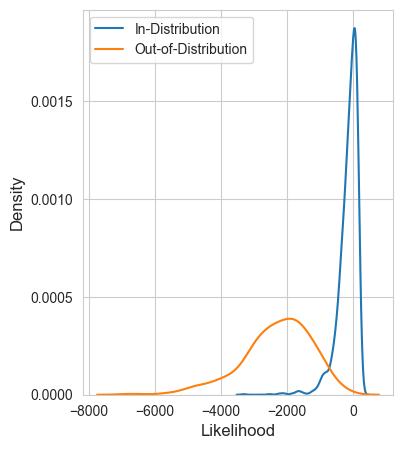

In [128]:
plt.figure(figsize=(4,5))
sns.kdeplot(in_scores)
sns.kdeplot(ood_scores2)
plt.xlabel('Likelihood')
plt.legend(['In-Distribution','Out-of-Distribution'])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

(array([4.31454876e-06, 1.07863719e-05, 2.58872925e-05, 2.37300182e-05,
        6.47182314e-05, 1.10020993e-04, 1.94154694e-04, 3.55950273e-04,
        3.73208468e-04, 9.70773471e-05]),
 array([-7817.4940114 , -7023.74761373, -6230.00121605, -5436.25481838,
        -4642.5084207 , -3848.76202303, -3055.01562535, -2261.26922767,
        -1467.52283   ,  -673.77643232,   119.96996535]),
 <BarContainer object of 10 artists>)

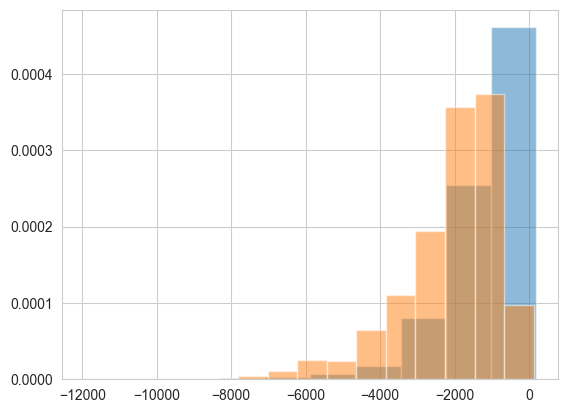

In [62]:
plt.hist(in_scores, density=True, alpha=0.5)
plt.hist(ood_scores, density=True, alpha=0.5)

## MSP 

In [63]:
from torch.nn.functional import softmax

In [64]:
np_labels = None 
np_logits = None 

for batch in train_loader:
    input, label = batch
    input = Variable(input).to(device)
    labels = label.numpy()
    model.eval()
    with torch.no_grad():
        output = model(input)

        logits = output.logits.detach().cpu().numpy()
        
        if np_logits is None:
            np_labels = labels 
            np_logits = logits
                
        else:
            np_logits = np.vstack((np_logits, logits))
            np_labels = np.concatenate((np_labels, labels))

In [65]:
logit_means = []
logit_stds = []
for i in np.unique(np_labels):
    class_logits = np_logits[np_labels==i,i] 
    print(f'Class {i}')
    print(np.mean(class_logits))
    print(np.std(class_logits))
    logit_means.append(np.mean(class_logits))
    logit_stds.append(np.std(class_logits))

torch_means = torch.tensor(logit_means).to(device)
torch_stds = torch.tensor(logit_means).to(device)

Class 0
2.4557607
1.8234706
Class 1
0.66729724
1.3308454
Class 2
3.7445138
1.5003132
Class 3
1.3325037
1.1972572


In [66]:
msp_id_features = None

for batch in id_loader:
    input, label = batch
    input = Variable(input).to(device)
    labels = label.numpy()
    model.eval()
    with torch.no_grad():
        output = model(input)


        out_logits = (output.logits - torch_means)/torch_stds
        msp, _ = torch.max(softmax(out_logits, dim = 1),axis=1)
        # msp, _ = torch.max(softmax(output.logits, dim = 1),axis=1)
        msp = msp.detach().cpu().numpy()
        
        if msp_id_features is None:
            msp_id_features = msp 
                
        else:
            msp_id_features = np.concatenate((msp_id_features, msp))
            

In [67]:
def msp_get_features(model, ood_loader):
    msp_ood_features = None

    for batch in ood_loader:
        if len(batch) == 2:
            input, label = batch
        else:
            input = batch
        input = Variable(input).to(device)
        model.eval()
        with torch.no_grad():
            output = model(input)


            out_logits = (output.logits - torch_means)/torch_stds
            msp, _ = torch.max(softmax(out_logits, dim = 1),axis=1)
            # msp, _ = torch.max(softmax(output.logits, dim = 1),axis=1)
            msp = msp.detach().cpu().numpy()
            
            if msp_ood_features is None:
                    msp_ood_features = msp 
                    
            else:
                msp_ood_features = np.concatenate((msp_ood_features, msp))
    
    return msp_ood_features

In [68]:
msp_ood_features = msp_get_features(model, ood_loader)
msp_ood_features2 = msp_get_features(model, ood_loader2)
msp_ood_features3 = msp_get_features(model, ood_loader3)
msp_ood_features4 = msp_get_features(model, ood_loader4)

In [69]:
# msp_ood_features2 = None

# for batch in ood_loader2:
#     input = Variable(batch).to(device)
#     model.eval()
#     with torch.no_grad():
#         output = model(input)


#         out_logits = (output.logits - torch_means)/torch_stds
#         msp, _ = torch.max(softmax(out_logits, dim = 1),axis=1)
#         # msp, _ = torch.max(softmax(output.logits, dim = 1),axis=1)
#         msp = msp.detach().cpu().numpy()
        
#         if msp_ood_features2 is None:
#                 msp_ood_features2 = msp 
                
#         else:
#             msp_ood_features2 = np.concatenate((msp_ood_features2, msp))
            

## Results MSP

In [70]:
print(f'Experiment 1: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(msp_id_features.reshape(-1,1), msp_ood_features.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')

print(f'Experiment 2: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(msp_id_features.reshape(-1,1), msp_ood_features2.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 3: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(msp_id_features.reshape(-1,1), msp_ood_features3.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Experiment 4: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(msp_id_features.reshape(-1,1), msp_ood_features4.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


Experiment 1: 
AUROC = 0.6243761388302081, AUPR = 0.8034893056063083, FPR95 = 0.851027397260274
0.6244 & 0.8035 & 0.851
Experiment 2: 
AUROC = 0.32332633191370846, AUPR = 0.7804446042233901, FPR95 = 0.9635036496350365
0.3233 & 0.7804 & 0.9635
Experiment 3: 
AUROC = 0.6209669877489946, AUPR = 0.957954071425523, FPR95 = 0.9411764705882353
0.621 & 0.958 & 0.9412
Experiment 4: 
AUROC = 0.5349551231904173, AUPR = 0.9312833149905833, FPR95 = 0.9365079365079365
0.535 & 0.9313 & 0.9365


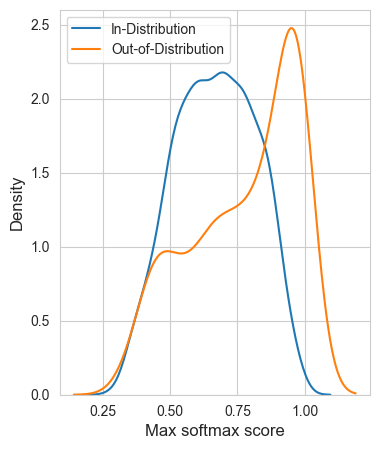

In [72]:
plt.figure(figsize=(4,5))

sns.kdeplot(msp_id_features)
sns.kdeplot(msp_ood_features2)
plt.xlabel('Max softmax score')
plt.legend(['In-Distribution','Out-of-Distribution'])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

(array([0.38289915, 1.09399756, 1.03929768, 0.87519805, 1.20339732,
        1.09399756, 1.20339732, 1.53159659, 1.69569622, 4.86828915]),
 array([0.33204943, 0.39877051, 0.46549159, 0.53221267, 0.59893376,
        0.66565484, 0.73237592, 0.799097  , 0.86581808, 0.93253917,
        0.99926025]),
 <BarContainer object of 10 artists>)

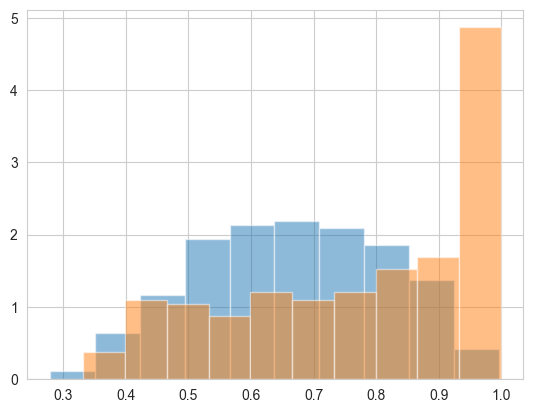

In [73]:
plt.hist(msp_id_features, density=True, alpha=0.5)
plt.hist(msp_ood_features2, density=True, alpha=0.5)

## Energy OOD Detection

In [74]:
id_features = None

temp = 1

for batch in id_loader:
    input, label = batch
    input = Variable(input).to(device)
    labels = label.numpy()
    model.eval()
    with torch.no_grad():
        output = model(input)

        out = temp*torch.logsumexp(output.logits/temp,dim=1)
        energy = out.detach().cpu().numpy()
        
        if id_features is None:
                id_features = energy 
                
        else:
            id_features = np.concatenate((id_features, energy))
            

In [75]:
def energy_get_features(model, ood_loader):
    ood_features = None

    temp = 1

    for batch in ood_loader:
        if len(batch) == 2:
            input, label = batch
        else:
            input = batch
        input = Variable(input).to(device)
        
        model.eval()
        with torch.no_grad():
            output = model(input)

            out = temp*torch.logsumexp(output.logits/temp,dim=1)
            energy = out.detach().cpu().numpy()
            
            if ood_features is None:
                    ood_features = energy 
                    
            else:
                ood_features = np.concatenate((ood_features, energy))

    return ood_features
            

In [76]:
ood_features  = energy_get_features(model, ood_loader)
ood_features2 = energy_get_features(model, ood_loader2)
ood_features3 = energy_get_features(model, ood_loader3)
ood_features4 = energy_get_features(model, ood_loader4)

In [77]:
# ood_features2 = None

# temp = 1

# for batch in ood_loader2:
    
#     input = Variable(batch).to(device)
#     model.eval()
#     with torch.no_grad():
#         output = model(input)

#         out = temp*torch.logsumexp(output.logits/temp,dim=1)
#         energy = out.detach().cpu().numpy()
        
#         if ood_features2 is None:
#                 ood_features2 = energy 
                
#         else:
#             ood_features2 = np.concatenate((ood_features2, energy))
            

## Results Energy 

In [78]:
print(f'Results experiment 1: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(id_features.reshape(-1,1), ood_features.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Results experiment 2: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(id_features.reshape(-1,1), ood_features2.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Results experiment 3: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(id_features.reshape(-1,1), ood_features3.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


print(f'Results experiment 4: ')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(id_features.reshape(-1,1), ood_features4.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in}, FPR95 = {fpr}')
print(f'{round(auroc,4)} & {round(aupr_in,4)} & {round(fpr,4)}')


Results experiment 1: 
AUROC = 0.6829569295322719, AUPR = 0.8642148099783898, FPR95 = 0.8664383561643836
0.683 & 0.8642 & 0.8664
Results experiment 2: 
AUROC = 0.6344852796119435, AUPR = 0.9318029596005007, FPR95 = 0.9781021897810219
0.6345 & 0.9318 & 0.9781
Results experiment 3: 
AUROC = 0.6656067832538421, AUPR = 0.9766794472144623, FPR95 = 0.9607843137254902
0.6656 & 0.9767 & 0.9608
Results experiment 4: 
AUROC = 0.6265971854207149, AUPR = 0.9673951292431617, FPR95 = 0.9761904761904762
0.6266 & 0.9674 & 0.9762


In [79]:
class GradVec():

    def __init__(self, n_components = 3, temp=1.0, n_classes=1, computed_grad=False, gamma = 2.0, alpha=1.5):
        self.components = n_components 
        self.temp = temp
        self.n_classes = n_classes
        self.computed_grad = computed_grad
        self.gamma = gamma 
        self.alpha = alpha 
        
    def get_gradients(self,model, loader, device, training_set = True):

        confs = []
        labels_ = []
        
        for b in tqdm(loader):

            if training_set:
                input_ids, labels = b 
                input_ids = Variable(input_ids).to(device)
                labels = labels.cpu().numpy()
                labels_.extend(labels)

            else:
                input_ids = Variable(b).to(device)

            logits = model(input_ids)        
            
            targets = (torch.ones((logits.logits.shape[0], logits.logits.shape[1]))/self.n_classes).cuda()
            outputs = logits.logits / self.temp
            
            ce_loss = torch.sum(-targets * F.log_softmax(outputs, dim=-1), dim=-1)
            pt = torch.exp(-ce_loss)
            loss1 = self.alpha * (1-pt)**self.gamma * ce_loss
        
            
            #loss1 = criterion(targets, outputs)
            
            for loss in loss1:  
                model.zero_grad()
                loss.backward(retain_graph=True)

                layer_grad = model.classifier.weight.grad.data
                layer_vec = torch.mean(torch.abs(layer_grad), dim=0).cpu().numpy()
                confs.append(layer_vec)

                        
        if training_set:
            return np.array(confs), np.array(labels_)
        else:
            return np.array(confs), None


    def fit_PCA(self, model, loader, device, labels=None):
        self.pca_ = {} 

        if not self.computed_grad:
            in_scores, labels = self.get_gradients(model, loader, device, training_set = True)
        else: 
            in_scores = loader 

        for i in np.unique(labels):
            #pca = PCA(n_components=self.components)
            pca = GaussianMixture(n_components=1)
            
            X_fit = in_scores[labels==i]
            pca.fit(X_fit)
            self.pca_[f'pca_{i}'] = pca

    def get_PCA_scores(self,model, loader, device, training_set = True):

        if not self.computed_grad:
            grads, labels = self.get_gradients(model, loader, device, training_set = training_set)
        else:
            grads = loader
        scores_ = []
        for _, estimator in self.pca_.items():
            scores = estimator.score_samples(grads)
            scores_.append(scores)
        
        grad_scores = np.max(np.array(scores_), axis=0)

        if training_set:
            return grad_scores, labels
        else:
            return grad_scores, None 

In [80]:
gradvec = GradVec(n_components=250, temp = 0.001, n_classes=5)

In [81]:
for param in model.parameters():
    param.requires_grad = False 

model.classifier.weight.requires_grad = True 
model.classifier.bias.requires_grad = True 

In [82]:
gradvec.fit_PCA(model, train_loader, device)

100%|██████████| 236/236 [01:17<00:00,  3.06it/s]


In [83]:
in_grads, labels_in = gradvec.get_PCA_scores(model, id_loader, device, training_set = True)
ood_grads, labels_ood = gradvec.get_PCA_scores(model, ood_loader, device, training_set = True)
ood_grads2, _ = gradvec.get_PCA_scores(model, ood_loader2, device, training_set = False)
ood_grads3, _ = gradvec.get_PCA_scores(model, ood_loader3, device, training_set = False)
ood_grads4, _ = gradvec.get_PCA_scores(model, ood_loader4, device, training_set = False)


100%|██████████| 126/126 [00:01<00:00, 113.09it/s]


In [84]:
print(f'Experiment 1:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_grads.reshape(-1,1), ood_grads.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')

print(f'Experiment 2:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_grads.reshape(-1,1), ood_grads2.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')

print(f'Experiment 3:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_grads.reshape(-1,1), ood_grads3.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')

print(f'Experiment 4:')
auroc, aupr_in, aupr_out, fpr, fpr_, tpr_ = get_measures(in_grads.reshape(-1,1), ood_grads4.reshape(-1,1))
print(f'AUROC = {auroc}, AUPR = {aupr_in} FPR95 = {fpr}')

Experiment 1:
AUROC = 0.761737664336375, AUPR = 0.9134252308900519 FPR95 = 0.7945205479452054
Experiment 2:
AUROC = 0.9862485929467467, AUPR = 0.9979918609188729 FPR95 = 0.0364963503649635
Experiment 3:
AUROC = 0.9908507123039995, AUPR = 0.999499422671143 FPR95 = 0.029411764705882353
Experiment 4:
AUROC = 0.9833657186598364, AUPR = 0.9989072467412151 FPR95 = 0.047619047619047616


In [85]:
grads_minor = in_grads[in_grads<-3773.19254768441]
grads_label = labels_in[in_grads<-3773.19254768441]

(array([  96.,    0.,    0.,  239.,    0.,    0., 1319.,    0.,    0.,
         233.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

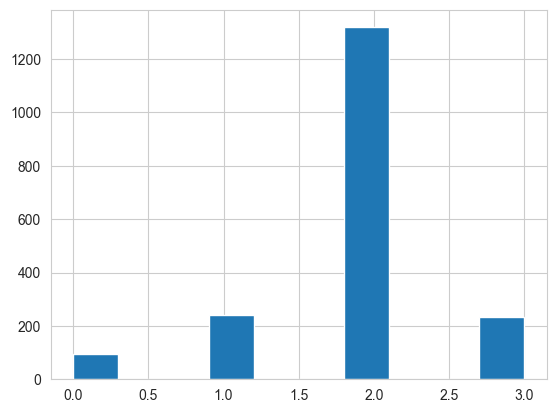

In [86]:
plt.hist(labels_in)

In [87]:
g_, c_ = np.unique(grads_label,return_counts=True)

_, c__ = np.unique(labels_in,return_counts=True)

In [88]:
c_/c__

array([1., 1., 1., 1.])

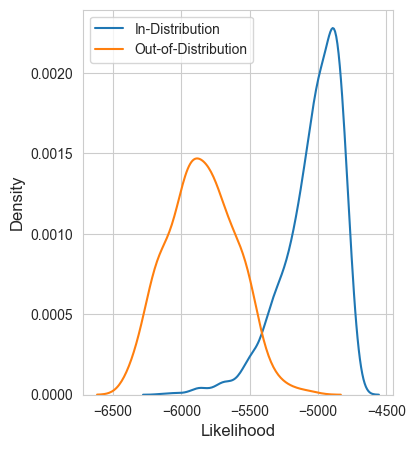

In [89]:
plt.figure(figsize=(4,5))
sns.kdeplot(in_grads)
sns.kdeplot(ood_grads2)
plt.xlabel('Likelihood')
plt.legend(['In-Distribution','Out-of-Distribution'])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

In [90]:
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
import numpy as np 

def stable_cumsum(arr, rtol=1e-05, atol=1e-08):
    """Use high precision for cumsum and check that final value matches sum
    Parameters
    ----------
    arr : array-like
        To be cumulatively summed as flat
    rtol : float
        Relative tolerance, see ``np.allclose``
    atol : float
        Absolute tolerance, see ``np.allclose``
    """
    out = np.cumsum(arr, dtype=np.float64)
    expected = np.sum(arr, dtype=np.float64)
    if not np.allclose(out[-1], expected, rtol=rtol, atol=atol):
        raise RuntimeError('cumsum was found to be unstable: '
                           'its last element does not correspond to sum')
    return out

def fpr_and_fdr_at_recall(y_true, y_score, recall_level, pos_label=1.):
    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = stable_cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps      # add one because of zero-based indexing

    thresholds = y_score[threshold_idxs]

    recall = tps / tps[-1]

    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)      # [last_ind::-1]
    recall, fps, tps, thresholds = np.r_[recall[sl], 1], np.r_[fps[sl], 0], np.r_[tps[sl], 0], thresholds[sl]

    cutoff = np.argmin(np.abs(recall - recall_level))
    print(thresholds[cutoff])
    return fps[cutoff] / (np.sum(np.logical_not(y_true)))   # , fps[cutoff]/(fps[cutoff] + tps[cutoff])

def get_measures(in_examples, out_examples):
    num_in = in_examples.shape[0]
    num_out = out_examples.shape[0]

    # logger.info("# in example is: {}".format(num_in))
    # logger.info("# out example is: {}".format(num_out))

    labels = np.zeros(num_in + num_out, dtype=np.int32)
    labels[:num_in] += 1

    examples = np.squeeze(np.vstack((in_examples, out_examples)))
    aupr_in = average_precision_score(labels, examples)
    auroc = roc_auc_score(labels, examples)

    recall_level = 0.95
    fpr = fpr_and_fdr_at_recall(labels, examples, recall_level)

    labels_rev = np.zeros(num_in + num_out, dtype=np.int32)
    labels_rev[num_in:] += 1
    examples = np.squeeze(-np.vstack((in_examples, out_examples)))
    aupr_out = average_precision_score(labels_rev, examples)

    fpr_, tpr_, _ = roc_curve(labels, examples)


    return auroc, aupr_in, aupr_out, fpr, fpr_, tpr_

(array([  96.,    0.,    0.,  239.,    0.,    0., 1319.,    0.,    0.,
         233.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

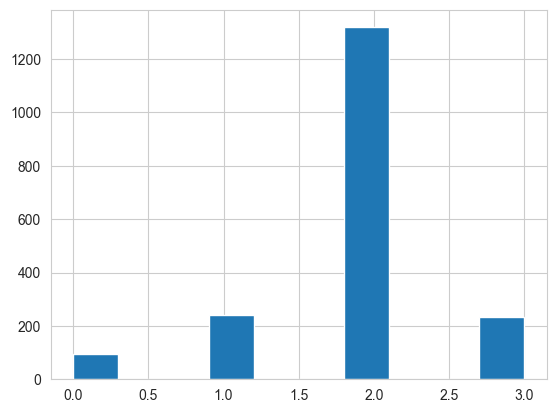

In [91]:
plt.hist(labels_in)

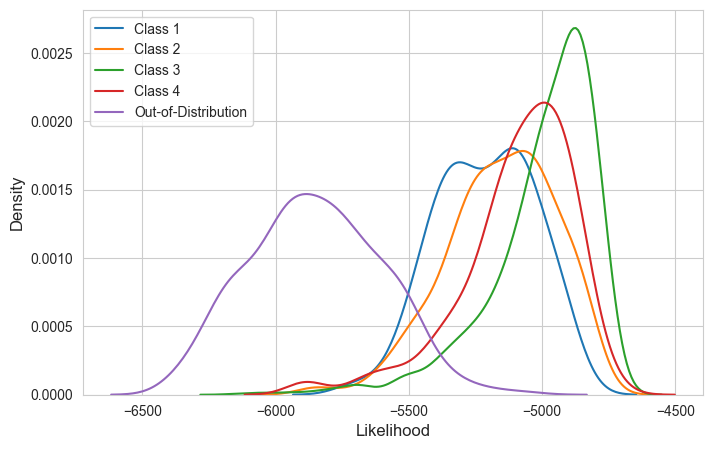

In [92]:
plt.figure(figsize=(8,5))
legends = []
for i in np.unique(labels_in):
    sns.kdeplot(in_grads[labels_in==i])
    legends.append(f'Class {i+1}')
sns.kdeplot(ood_grads2)
legends.append('Out-of-Distribution')
plt.xlabel('Likelihood')
plt.legend(legends)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

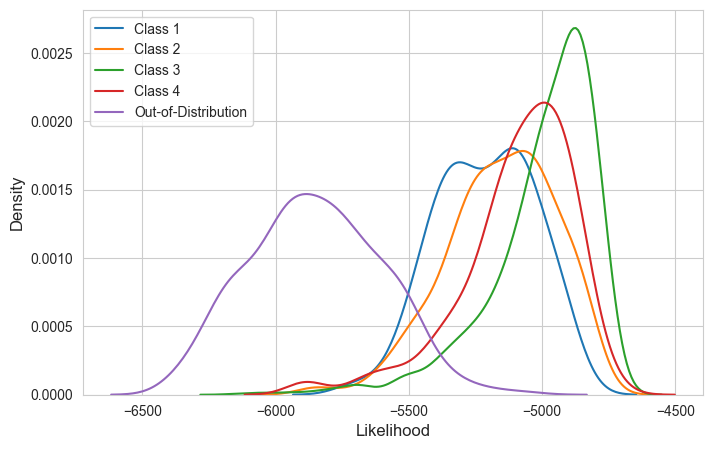

In [93]:
plt.figure(figsize=(8,5))
legends = []
for i in np.unique(labels_in):
    sns.kdeplot(in_grads[labels_in==i])
    legends.append(f'Class {i+1}')
sns.kdeplot(ood_grads2)
legends.append('Out-of-Distribution')
plt.xlabel('Likelihood')
plt.legend(legends)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

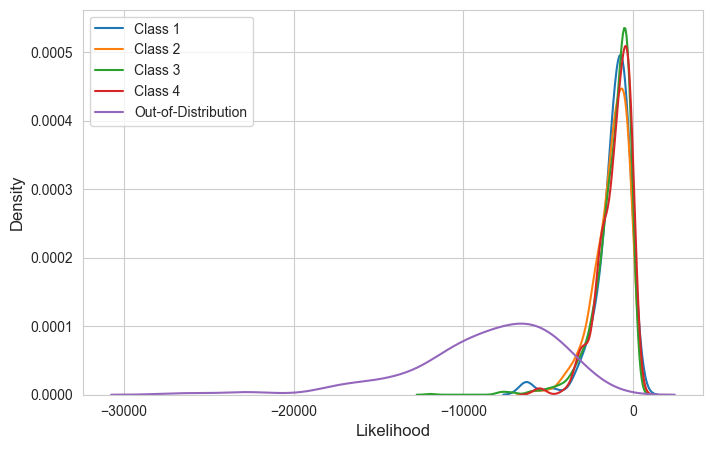

In [94]:
plt.figure(figsize=(8,5))
legends = []
for i in np.unique(labels_in):
    sns.kdeplot(in_scores[labels_in==i])
    legends.append(f'Class {i+1}')
sns.kdeplot(ood_scores2)
legends.append('Out-of-Distribution')
plt.xlabel('Likelihood')
plt.legend(legends)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

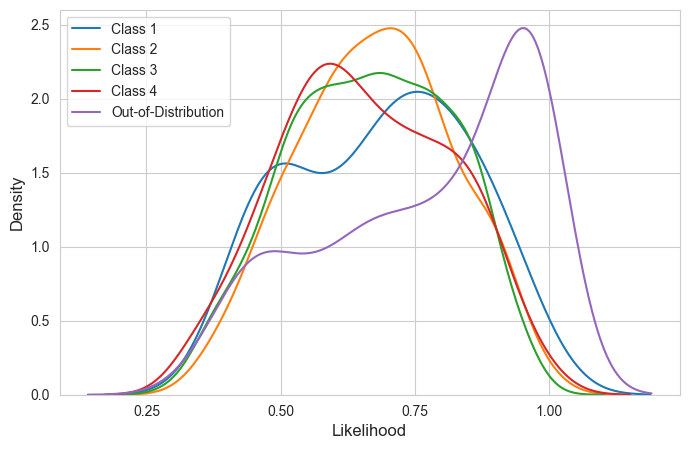

In [95]:
plt.figure(figsize=(8,5))
legends = []
for i in np.unique(labels_in):
    sns.kdeplot(msp_id_features[labels_in==i])
    legends.append(f'Class {i+1}')
sns.kdeplot(msp_ood_features2)
legends.append('Out-of-Distribution')
plt.xlabel('Likelihood')
plt.legend(legends)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)